In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install utils

In [ ]:
import os
import glob
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from utils import *
%matplotlib inline

In [ ]:
'''read csv data at load_path and return it in a numpy matrix'''
def get_day_load_data(load_path):
    data = pd.read_csv(load_path)
    # get date in the format- '01-10-2017'
    date_ = load_path.split('/')[-1][:-4]
    data['date'] = datetime.strptime(date_, "%d-%m-%Y").date()
    data['time'] += ':00'
    data['datetime'] = pd.to_timedelta(data['time'])
    data['hour'] = data['datetime'].dt.seconds // 3600
    return data.to_numpy()

In [ ]:
'''Returns time, day, temp, humidity and load values for each 30mins in a numpy matrix'''
def get_30min_wise_data(day_load_data):
    data = []
    # SLDC load data has time step of 5 mins. Hence, total of 24 * (60 // 5)
    for i in range(0, 288, 6):
        load = day_load_data[i][1]
        day = day_load_data[i][2].weekday()

        try:
            humidity = 55
         # some dirt values in data
        except Exception as e:
            humidity = 50
        try:
            temp = float(day_whether_data[i//6][0]) # i//6 because whether data is already in 30 min step size
        except Exception as err:
            temp = 28 # aiyvi
        data.append([i, day, temp, humidity, load])
    return np.asarray(data)

In [ ]:
'''Return data of all csv files in SLDC_Data/ folder in matrix form'''
def get_data(data_list, shuffle=True):
    data = []
    for load_path in data_list:
        try:
            # whether_path = load_path.replace('SLDC_Data', 'Whether_Data')
            day_load_data = get_day_load_data(load_path)
            # day_whether_data = pd.read_csv(whether_path)
            day_data = get_30min_wise_data(day_load_data)
            data.append(day_data)
        except Exception as e:
            print(load_path, e)
    # (115, 48, 5)
    data = np.asarray(data)
    # (5520, 5)
    data = data.reshape(-1, 5)
    if shuffle: np.random.shuffle(data)
    return data

In [ ]:
# Doing data preprocessing
data_list = glob.glob('/content/drive/MyDrive/SLDC_Data/*/*/*.csv')
train, test = train_test_split(data_list, test_size=0.1)
train_data = get_data(train)
# features
X_train = train_data[:, :-1]
 # load, reshaped to 2D
Y_train = train_data[:, -1].reshape(-1, 1)

/content/drive/MyDrive/SLDC_Data/2023/01/19-01-2023.csv index 276 is out of bounds for axis 0 with size 275
/content/drive/MyDrive/SLDC_Data/2022/11/10-11-2022.csv index 252 is out of bounds for axis 0 with size 249
/content/drive/MyDrive/SLDC_Data/2022/10/09-10-2022.csv index 204 is out of bounds for axis 0 with size 204
/content/drive/MyDrive/SLDC_Data/2023/02/03-02-2023.csv index 168 is out of bounds for axis 0 with size 167
/content/drive/MyDrive/SLDC_Data/2022/11/30-11-2022.csv index 180 is out of bounds for axis 0 with size 176
/content/drive/MyDrive/SLDC_Data/2022/12/02-12-2022.csv index 258 is out of bounds for axis 0 with size 256
/content/drive/MyDrive/SLDC_Data/2023/01/04-01-2023.csv index 252 is out of bounds for axis 0 with size 251
/content/drive/MyDrive/SLDC_Data/2023/01/18-01-2023.csv index 240 is out of bounds for axis 0 with size 239
/content/drive/MyDrive/SLDC_Data/2022/12/01-12-2022.csv index 66 is out of bounds for axis 0 with size 65
/content/drive/MyDrive/SLDC_Da

In [ ]:
X_train

In [ ]:
Y_train

array([[1710.36],
       [4563.51],
       [3779.22],
       ...,
       [1707.44],
       [1874.69],
       [2453.93]])

In [ ]:
# rescale the data to 0-1 values`
feature_scaler = MinMaxScaler(feature_range=(0, 1))
# try StandardScaler()
load_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = feature_scaler.fit_transform(X_train)
Y_train = load_scaler.fit_transform(Y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (5664, 4, 1) y_train : (5664, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.optimizers import RMSprop

In [ ]:
def getModel(num_units=32, num_dense=1, time_steps=3):
    model = Sequential()
    model.add(LSTM(50, return_sequences = True, input_shape = (4,1)))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ["accuracy"])

    return model

In [ ]:
model = getModel(num_units=128, num_dense=1, time_steps=8)

In [ ]:
model.fit(X_train, Y_train, epochs=20, batch_size=4, verbose=2)

Epoch 1/20
1416/1416 - 21s - loss: 0.0356 - accuracy: 1.7655e-04 - 21s/epoch - 15ms/step
Epoch 2/20
1416/1416 - 11s - loss: 0.0241 - accuracy: 3.5311e-04 - 11s/epoch - 8ms/step
Epoch 3/20
1416/1416 - 7s - loss: 0.0206 - accuracy: 3.5311e-04 - 7s/epoch - 5ms/step
Epoch 4/20
1416/1416 - 6s - loss: 0.0176 - accuracy: 3.5311e-04 - 6s/epoch - 4ms/step
Epoch 5/20
1416/1416 - 8s - loss: 0.0170 - accuracy: 3.5311e-04 - 8s/epoch - 6ms/step
Epoch 6/20
1416/1416 - 6s - loss: 0.0167 - accuracy: 3.5311e-04 - 6s/epoch - 4ms/step
Epoch 7/20
1416/1416 - 8s - loss: 0.0165 - accuracy: 3.5311e-04 - 8s/epoch - 6ms/step
Epoch 8/20
1416/1416 - 6s - loss: 0.0162 - accuracy: 3.5311e-04 - 6s/epoch - 5ms/step
Epoch 9/20
1416/1416 - 7s - loss: 0.0158 - accuracy: 3.5311e-04 - 7s/epoch - 5ms/step
Epoch 10/20
1416/1416 - 8s - loss: 0.0157 - accuracy: 3.5311e-04 - 8s/epoch - 6ms/step
Epoch 11/20
1416/1416 - 6s - loss: 0.0153 - accuracy: 3.5311e-04 - 6s/epoch - 4ms/step
Epoch 12/20
1416/1416 - 9s - loss: 0.0151 - acc

In [ ]:
'''selects a date in data and plots the predicted curve using the trained model'''
def predict(data):
    try:
        # to select a date in data data
        x = np.random.randint(len(data))
        data_data = get_data([data[x]], shuffle=False)
        X_data = data_data[:, :-1] # features
        Y_data = data_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

        X_data = feature_scaler.fit_transform(X_data)
        Y_data = load_scaler.fit_transform(Y_data)

        preds = model.predict(X_data)

        preds = load_scaler.inverse_transform(preds)

        Y_ = load_scaler.inverse_transform(Y_data)
        plt.plot(range(len(Y_)), Y_)
        plt.plot(range(len(preds)), preds)
        plt.legend(['actual', 'pred'])
        plt.title(data[x])
        plt.show()
    except Exception as e:
        print('Err in data', e)

2/2 [==============================] - 1s 12ms/step


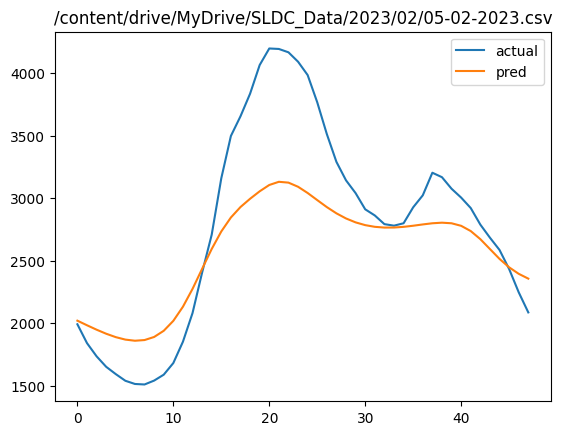

In [ ]:
# prediction on test data
predict(test)

2/2 [==============================] - 0s 7ms/step


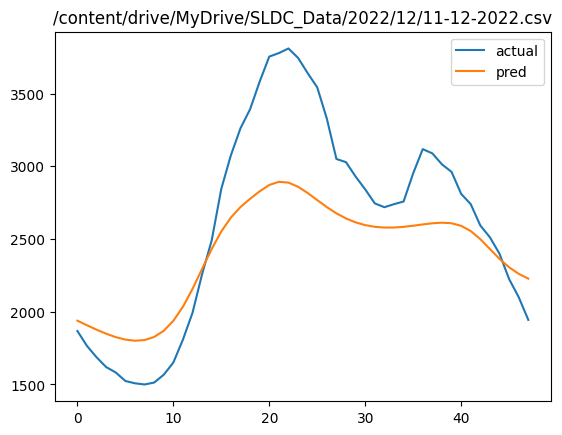

In [ ]:
# prediction on train data
predict(train)

In [ ]:
from sklearn.metrics import mean_absolute_error

/content/drive/MyDrive/SLDC_Data/2023/01/19-01-2023.csv index 276 is out of bounds for axis 0 with size 275
/content/drive/MyDrive/SLDC_Data/2022/11/10-11-2022.csv index 252 is out of bounds for axis 0 with size 249
/content/drive/MyDrive/SLDC_Data/2022/10/09-10-2022.csv index 204 is out of bounds for axis 0 with size 204
/content/drive/MyDrive/SLDC_Data/2023/02/03-02-2023.csv index 168 is out of bounds for axis 0 with size 167
/content/drive/MyDrive/SLDC_Data/2022/11/30-11-2022.csv index 180 is out of bounds for axis 0 with size 176
/content/drive/MyDrive/SLDC_Data/2022/12/02-12-2022.csv index 258 is out of bounds for axis 0 with size 256
/content/drive/MyDrive/SLDC_Data/2023/01/04-01-2023.csv index 252 is out of bounds for axis 0 with size 251
/content/drive/MyDrive/SLDC_Data/2023/01/18-01-2023.csv index 240 is out of bounds for axis 0 with size 239
/content/drive/MyDrive/SLDC_Data/2022/12/01-12-2022.csv index 66 is out of bounds for axis 0 with size 65
/content/drive/MyDrive/SLDC_Da

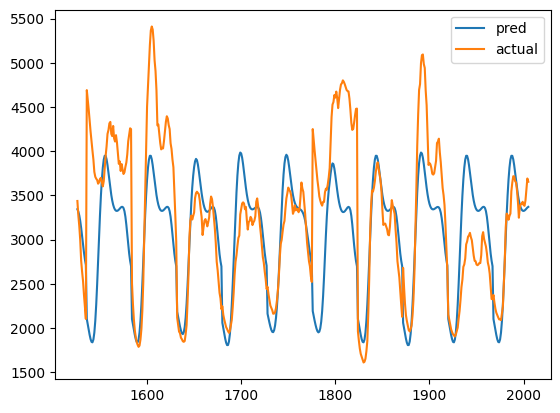

In [ ]:
# prediction on train data as a whole
train_data = get_data(train, shuffle=False)

# features
X_train = train_data[:, :-1]

# load, reshaped to 2D
Y_train = train_data[:, -1].reshape(-1, 1)

X_data = feature_scaler.fit_transform(X_train)
Y_data = load_scaler.fit_transform(Y_train)

preds = model.predict(X_data)
preds = load_scaler.inverse_transform(preds)

Y_ = load_scaler.inverse_transform(Y_data)

x = np.random.randint(len(preds))
x_max = 480
print(mean_absolute_error(Y_, preds))
print(x,x+x_max)
plt.plot(range(x, x+x_max), preds[x:x+x_max])
plt.plot(range(x, x+x_max), Y_[x:x+x_max])
plt.legend(['pred', 'actual'])
plt.show()